In [6]:
pwd

'c:\\Users\\tanbe\\OneDrive\\Desktop\\Works\\HWUM\\FYP\\fakefacedetect\\notebooks'

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, log_loss
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

import os
import sys

src_path = r"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\src\utils"
sys.path.append(src_path)

import operation_utils as utils
import preprocess_utils as preprocess
import modeling_utils as modeling

In [2]:
dataset='real_and_fake_face_2'
seed=17
benchmark=1  #processed npy
output_benchmark=2 #extracted npy
output_train_dir = rf"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\processed\{dataset}\train"
output_test_dir = rf"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\processed\{dataset}\test"

model_benchmark=1
output_model_dir=rf'C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\models\{dataset}_{output_benchmark}'
utils.create_dir(output_model_dir)

In [3]:
train_features_path = rf"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\processed\{dataset}\train\features_{benchmark}.npy"
train_labels_path = rf"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\processed\{dataset}\train\labels_{benchmark}.npy"
test_features_path = rf"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\processed\{dataset}\test\features_{benchmark}.npy"
test_labels_path = rf"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\processed\{dataset}\test\labels_{benchmark}.npy"


train_features = np.load(train_features_path)
y_train = np.load(train_labels_path)

test_features = np.load(test_features_path)
y_test = np.load(test_labels_path)

print("Trian npy shape:")
print(train_features.shape)
print(y_train.shape)
print("\nTest npy shape:")
print(test_features.shape)
print(y_test.shape)

Trian npy shape:
(1632, 224, 224)
(1632,)

Test npy shape:
(409, 224, 224)
(409,)


In [111]:
#Check Renet-18 Layers
#Set input data to 1 channel and remove the last layer (fully connected) to get features from the last convolutional layer
import torch.nn as nn
import torchvision.transforms as transforms

# Modify the first convolutional layer to accept 1 channel instead of 3
resnet18.conv1 = nn.Conv2d(
    in_channels=1,     # Set to 1 for grayscale
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False
)
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])


# Set the model to evaluation mode
resnet18.eval()

# Check the modified structure
print("Modified ResNet-18 Layers:")
print(feature_extractor)


Modified ResNet-18 Layers:
Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

In [53]:
# Test with input RGB image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load ResNet18 and modify it for feature extraction
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()  # Set to evaluation mode
# Remove the last layer (fully connected) to get features from the last convolutional layer
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])

# Define the transformations, including resizing, converting to tensor, and normalizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load a sample grayscale image and duplicate channels to make it compatible with ResNet
image = Image.open(r"C:\Users\tanbe\OneDrive\Desktop\Works\HWUM\FYP\fakefacedetect\data\raw\real_and_fake_face_detection\real_and_fake_face\training_fake\easy_4_0011.jpg").convert("L")  # Load as grayscale
image = image.convert("RGB")  # Convert to RGB by duplicating channels

# Apply the transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Pass the image through the feature extractor
with torch.no_grad():
    features = feature_extractor(image_tensor)

# Flatten the output to get a 1D feature vector
features = features.view(features.size(0), -1).numpy()  # Convert to NumPy array if needed

print("Extracted features shape:", features.shape)



Extracted features shape: (1, 512)


c:\Users\tanbe\anaconda3\envs\fakefacedetect\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tanbe\anaconda3\envs\fakefacedetect\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [112]:
image_tensor = torch.tensor(features_array[0], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
image_tensor.size()

torch.Size([1, 1, 224, 224])

(array([5.28963460e-07, 2.11585384e-06, 4.38284010e-06, 9.40799297e-06,
        1.86648535e-05, 3.99745243e-05, 8.58809960e-05, 1.65716695e-04,
        3.21080820e-04, 6.26217170e-04, 1.21283765e-03, 2.30397592e-03,
        4.37815499e-03, 8.23278729e-03, 1.52159740e-02, 2.73420457e-02,
        4.80346428e-02, 8.20243990e-02, 1.35295402e-01, 2.12088504e-01,
        3.08283947e-01, 4.02998709e-01, 4.56689671e-01, 4.37368034e-01,
        3.49386562e-01, 2.37706469e-01, 1.44003010e-01, 8.35856725e-02,
        4.95715084e-02, 3.09489719e-02, 1.97992912e-02, 1.28288752e-02,
        8.33102336e-03, 5.40101919e-03, 3.48073070e-03, 2.21129396e-03,
        1.45041781e-03, 9.69816721e-04, 6.43068435e-04, 3.99140714e-04,
        2.14683599e-04, 1.23853016e-04, 6.31733504e-05, 2.47479333e-05,
        6.23421221e-06, 2.19142005e-06, 9.48355918e-06, 2.29721274e-05,
        2.25565133e-05, 4.00500905e-06]),
 array([ 0.0915657 ,  0.41477673,  0.73798775,  1.06119878,  1.38440981,
         1.70762084, 

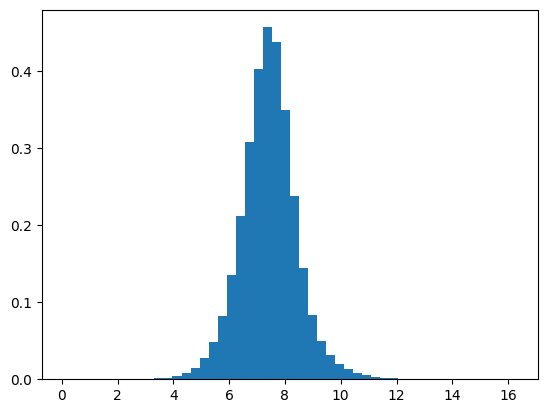

In [198]:
plt.hist(train_features.ravel(), bins=50, density=True)

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Sample data (replace this with your actual grayscale images array)
# Assuming `features_array` is a NumPy array with shape (409, 224, 224)
# Load ResNet18 and modify it for grayscale input

# Extract features in batches
class FeaturesEngineer():
    def __init__(self):
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer
        self.resnet.eval()  # Set model to evaluation mode

    def extract_feature(self, features):
        # Calculate mean and std for normalization
        extracted_features = []

        # mean, std = np.mean(features), np.std(features)
        mean=0.5
        std=0.2
        # Convert the NumPy array to a PyTorch tensor
        
        # Normalize the tensor
        transform_norm = transforms.Compose([
            transforms.Normalize(mean=[mean], std=[std])  # Mean and std should be lists
        ])
        
        features_tensor = torch.tensor(features, dtype=torch.float32)
        # Add a channel dimension to match the expected input shape of the model
        features_tensor = features_tensor.unsqueeze(1)  # (409, 1, 224, 224)

        # Normalize the tensor
        features_tensor = transform_norm(features_tensor)

        # Initialize DataLoader
        batch_size = 32  # Set batch size
        data_loader = DataLoader(features_tensor, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            for batch in data_loader:
                batch_features = self.resnet(batch)
                extracted_features.append(batch_features.numpy())

        # Concatenate all features into one array
        extracted_features = np.vstack(extracted_features)
        print("Extracted features shape:", extracted_features.shape)  # Expected shape: (409, 512)

        return extracted_features


In [5]:
Extract=FeaturesEngineer()
X_train=Extract.extract_feature(train_features)
X_test=Extract.extract_feature(test_features)

c:\Users\tanbe\anaconda3\envs\fakefacedetect\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tanbe\anaconda3\envs\fakefacedetect\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted features shape: (1632, 512)
Extracted features shape: (409, 512)


In [216]:
print(np.mean(X_train),np.std(X_train))
print(np.mean(X_test),np.std(X_test))

4.3382254 6.4713836
4.3323026 6.46417


In [217]:
print("Training data: ",X_train.shape)
print("Testing data: ",X_test.shape)

Training data:  (1632, 512)
Testing data:  (409, 512)


In [ ]:
model="svm"
trainer = modeling.ModelTrainer(model=model, checkpoint_dir=output_model_dir, model_benchmark=model_benchmark,random_state=seed)
model_params={
    "C": [1000],
    "kernel": ["rbf"],
    "gamma": [0.005,0.01]
}
    # Train models
    # First training session
if model=="svm":
    param_grid = {
        'svm__C': model_params['C'],
        'svm__kernel': model_params['kernel'],
        'svm__gamma': model_params['gamma']
    }
    print(model, param_grid)
    trainer.train_svm(X_train, y_train, param_grid['svm__C'], param_grid['svm__kernel'], param_grid['svm__gamma'], n_splits=5)
elif model=="knn":
    param_grid = {
        'knn__n_neighbors': model_params['n_neighbors'],
        'knn__weights': model_params['weights'],
        'knn__metric': model_params['metric']
    }
    print(model, param_grid)
    trainer.train_knn(X_train, y_train, param_grid,n_splits=5)

# Evaluate models
# X_test_scaled=trainer.scaler.fit_transform(X_test)
y_pred, results = trainer.evaluate_models(X_test, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()


print(f"\n{model} Results:")
print(f"Testing Accuracy: {results['accuracy']:.4f}")
print(f"Testing Precision: {results['precision']:.4f}")
print(f"Testing Loss: {results['loss']:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")


svm {'svm__C': [1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.005, 0.01]}
Starting SVM tuning with manual cross-validation...

Train size: 1632
Testing SVM with C=1000, kernel='rbf', gamma='0.005'
Number of folds: 5, Fold size: 326

Fold 1/5
    Accuracy: 0.5250, Precision: 0.4550, Recall: 0.4650,Specificity: 0.5710, F1-Score: 0.4600MCC: 0.0350, AUROC: 0.4730, Loss: 1.0620
    TP: 66, FP: 79, TN: 105, FN: 76

Fold 2/5
    Accuracy: 0.5180, Precision: 0.4930, Recall: 0.4770,Specificity: 0.5560, F1-Score: 0.4850MCC: 0.0330, AUROC: 0.4800, Loss: 1.0234
    TP: 74, FP: 76, TN: 95, FN: 81

Fold 3/5
    Accuracy: 0.5030, Precision: 0.4370, Recall: 0.4310,Specificity: 0.5600, F1-Score: 0.4340MCC: -0.0090, AUROC: 0.4450, Loss: 1.0558
    TP: 62, FP: 80, TN: 102, FN: 82

Fold 4/5
    Accuracy: 0.4790, Precision: 0.4640, Recall: 0.4400,Specificity: 0.5150, F1-Score: 0.4520MCC: -0.0450, AUROC: 0.4430, Loss: 1.0114
    TP: 70, FP: 81, TN: 86, FN: 89

Fold 5/5
    Accuracy: 0.5400, Precision: 0.5

In [ ]:
np.save(os.path.join(output_dir, f'labels_{output_benchmark}.npy'), extracted_features)

In [ ]:
log_data = {
    "dataset": data_dir,
    "prepare_benchmark": prepare_benchmark,
    "seed": seed,
    "train_test": train_test,
    "interpolation_resize": f"resize:{resize}, normalize:{normalize}, extract_stats:{extract_stats}",
    "preprocess_method": preprocess_method,
    "features_shape": features.shape,
    "labels_shape": labels.shape,
    "output_dir": output_dir,
        "runtime_seconds": runtime  # Log the runtime
}

# Path to log file
log_file_path = os.path.join(output_dir, "log.json")
utils.write_json(log_data, log_file_path)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import hinge_loss

k=3
weight='distance'
metric='minkowski'

pipeline = Pipeline([('knn', KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric, n_jobs=-1))])
pipeline.fit(X_train, y_train)
pipeline.predict(X_test)

# Convert predicted labels to decision function scores (-1 for 0, 1 for 1)
y_pred_scores = np.where(y_pred == 1, 1, -1)

# Calculate hinge loss
loss = hinge_loss(y_test, y_pred_scores)
print(loss)

NameError: name 'y_pred' is not defined

In [7]:
model='knn'
n_neighbors=[3, 5, 7, 9, 11]
weights=['uniform', 'distance']
metrics=['euclidean', 'manhattan']

trainer = modeling.ModelTrainer(model=model, checkpoint_dir=output_model_dir, model_benchmark=model_benchmark,random_state=seed)
trainer.train_knn(X_train, y_train, n_neighbors, weights, metrics, n_splits=5)
y_pred,results = trainer.evaluate_models(X_test, y_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"\n{model} Results:")
print(f"Testing Accuracy: {results['accuracy']:.4f}")
print(f"Testing Precision: {results['precision']:.4f}")
print(f"Testing Loss: {results['loss']:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Starting KNN tuning with manual cross-validation...

Train size: 1632
Testing KNN with k=3, weights='uniform', metric='euclidean'
Number of folds: 5, Fold size: 326

Fold 1/5
    Accuracy: 0.4740, Precision: 0.4430, Recall: 0.4550,Specificity: 0.4910, F1-Score: 0.4490MCC: -0.0540, AUROC: 0.4600, Loss: 1.0520
    TP: 70, FP: 88, TN: 85, FN: 84

Fold 2/5
    Accuracy: 0.5230, Precision: 0.4940, Recall: 0.5650,Specificity: 0.4860, F1-Score: 0.5270MCC: 0.0510, AUROC: 0.5580, Loss: 0.9541
    TP: 87, FP: 89, TN: 84, FN: 67

Fold 3/5
    Accuracy: 0.5120, Precision: 0.4810, Recall: 0.4970,Specificity: 0.5260, F1-Score: 0.4890MCC: 0.0230, AUROC: 0.4970, Loss: 0.9755
    TP: 76, FP: 82, TN: 91, FN: 77

Fold 4/5
    Accuracy: 0.5000, Precision: 0.4720, Recall: 0.4870,Specificity: 0.5120, F1-Score: 0.4790MCC: -0.0010, AUROC: 0.4880, Loss: 1.0000
    TP: 75, FP: 84, TN: 88, FN: 79

Fold 5/5
    Accuracy: 0.5310, Precision: 0.5030, Recall: 0.5450,Specificity: 0.5170, F1-Score: 0.5230MCC: 0.0630, A